In [38]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

In [39]:
X_train, y_train, X_valid, y_valid = load_data(test_size=0.1, img_size=224,Gray2RGB=True)

In [40]:
#X_test, X_id = load_test_data(Gray2RGB=True)
#model_name = 'classic_CNN_GlobalAveragePooling2D'
#model_path = './saved_models/{}_0426.h5'.format(model_name)
#model = load_model(model_path)

#scores = model.evaluate(X_valid, y_valid, verbose=1)
#print('Validation loss:', scores[0])
#print('Validation accuracy:', scores[1])

#y_test_pred = model.predict_classes(X_test)
#y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
#y_test_pred_df.to_csv('submissions_0426.csv'.format(model_name), index=False)

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(2686, 224, 224, 3)
(2686, 15)
(299, 224, 224, 3)
(299, 15)


In [42]:
# a classic CNN model
model_name = 'classic_CNN_GlobalAveragePooling2D'
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
model.add(BatchNormalization())


model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,  (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,  (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())

#model.add(Dropout(0.25))

# model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_32 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_33 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 112, 112, 64)      18496     
__________

In [44]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-4)

model_path = './saved_models/CNN_0427.h5'.format(model_name)
checkpoint = ModelCheckpoint(model_path, monitor='acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=16, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 64
aug_ratio = 2
epochs = 400
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint,earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps,
                                    workers=4)

Epoch 1/400
82/83 [============================>.] - ETA: 0s - loss: 2.0159 - acc: 0.3406
Epoch 00001: acc improved from -inf to 0.34156, saving model to ./saved_models/CNN_0427.h5
83/83 [==============================] - 43s 513ms/step - loss: 2.0140 - acc: 0.3415 - val_loss: 6.3732 - val_acc: 0.0301
Epoch 2/400
82/83 [============================>.] - ETA: 0s - loss: 1.6859 - acc: 0.4618
Epoch 00002: acc improved from 0.34156 to 0.46138, saving model to ./saved_models/CNN_0427.h5
83/83 [==============================] - 31s 370ms/step - loss: 1.6851 - acc: 0.4614 - val_loss: 3.8938 - val_acc: 0.0435
Epoch 3/400
82/83 [============================>.] - ETA: 0s - loss: 1.5246 - acc: 0.5286
Epoch 00003: acc improved from 0.46138 to 0.52826, saving model to ./saved_models/CNN_0427.h5
83/83 [==============================] - 31s 369ms/step - loss: 1.5244 - acc: 0.5282 - val_loss: 2.8652 - val_acc: 0.1438
Epoch 4/400
82/83 [============================>.] - ETA: 0s - loss: 1.4058 - acc: 0.

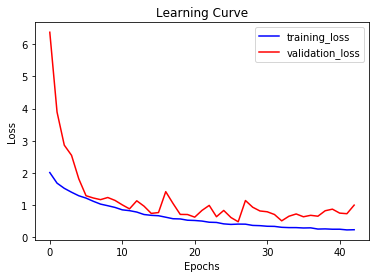

In [45]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, 'b', label="training_loss")
plt.plot(val_loss, 'r', label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

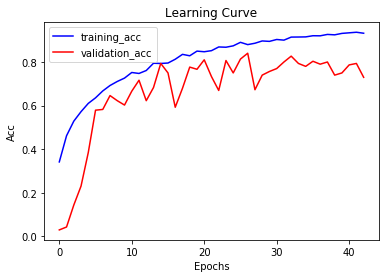

In [46]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, 'b', label="training_acc")
plt.plot(val_acc, 'r', label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [47]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(2686, 224, 224, 3)
(2686, 15)
(299, 224, 224, 3)
(299, 15)


In [48]:
X_test, X_id = load_test_data(Gray2RGB=True)
print(X_test.shape)

(1500, 224, 224, 3)


In [49]:
print(X_valid.shape)

(299, 224, 224, 3)


In [57]:
model_path = './saved_models/CNN_04303.h5'.format(model_name)
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('submissions_0430.csv'.format(model_name), index=False)

299/299 [==============================] - 2s 8ms/step
Validation loss: 0.7546437623907492
Validation accuracy: 0.7859531770581785


In [53]:
#X_train

In [ ]:
#X_test

In [ ]:
pp

In [9]:
# a classic CNN model
model_name = 'classic_CNN_GlobalAveragePooling2D'
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_7 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
activation_8 (Activation)    (None, 112, 112, 128)     0         
__________

In [10]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 16
aug_ratio = 1
epochs = 200
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/200
166/167 [============================>.] - ETA: 0s - loss: 2.5018 - acc: 0.1956
Epoch 00001: val_loss improved from inf to 3.03830, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
167/167 [==============================] - 15s 89ms/step - loss: 2.5013 - acc: 0.1955 - val_loss: 3.0383 - val_acc: 0.0569
Epoch 2/200
166/167 [============================>.] - ETA: 0s - loss: 2.0136 - acc: 0.3723
Epoch 00002: val_loss did not improve from 3.03830
167/167 [==============================] - 11s 66ms/step - loss: 2.0137 - acc: 0.3712 - val_loss: 3.1039 - val_acc: 0.0569
Epoch 3/200
166/167 [============================>.] - ETA: 0s - loss: 1.8644 - acc: 0.4287
Epoch 00003: val_loss improved from 3.03830 to 2.58687, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
167/167 [==============================] - 11s 66ms/step - loss: 1.8619 - acc: 0.4307 - val_loss: 2.5869 - val_acc: 0.1639
Epoch 4/200
166/167 [============================>.] - ETA

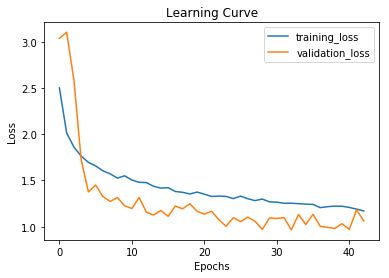

In [11]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

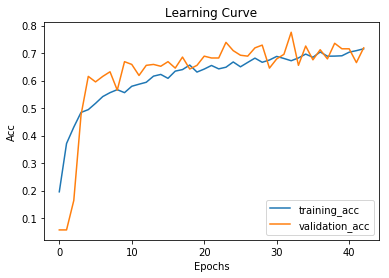

In [12]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [13]:
X_test, X_id = load_test_data()

model_path = './saved_models/{}.h5'.format(model_name)
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 1s 2ms/step
Validation loss: 0.9649896470200656
Validation accuracy: 0.775919732242125
